<a href="https://colab.research.google.com/github/Daniela159-8/Ejemplo/blob/main/Practica_Teledeteccion_GEE_Colab_(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🛰️ Teledetección e Inteligencia Artificial: Prácticas en Google Colab

# Nueva sección
Este notebook introduce el uso básico de **Google Earth Engine (GEE)** y **Python (con geemap)** para analizar imágenes satelitales. Aprenderás a:
- Cargar una imagen satelital de Landsat 8.
- Calcular y visualizar el NDVI.
- Extraer firmas espectrales de un punto.


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd /content/drive/MyDrive/Curso_CIATEJ_CUGDL/CLONE_PROJECT

/content/drive/MyDrive/Curso_CIATEJ_CUGDL/CLONE_PROJECT


In [4]:
!git clone https://github.com/Daniela159-8/Ejemplo.git

Cloning into 'Ejemplo'...
remote: Enumerating objects: 4, done.
remote: Counting objects: 100% (4/4), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 4 (delta 0), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (4/4), done.


**Pasos previos obligatorios para usar Google Earth Engine (GEE) con Python en Colab**

1. Crear una cuenta en Earth Engine

- Ir a https://earthengine.google.com/signup
- Iniciar sesión con una cuenta de Google.
- Completar el formulario con nombre, país, afiliación (puedes poner “estudiante” o el nombre de la institución).
- Aceptar los términos y enviar.

2. Crear un proyecto de Google Cloud Platform (GCP)

- Ir a https://console.cloud.google.com/
- Crear un nuevo proyecto (clic en el selector de proyectos → “Nuevo proyecto”).
- Asignarle un nombre (ej. gee-colab-practicas) y hacer clic en "Crear".

3. Habilitar la API de Earth Engine en ese proyecto
- Con el proyecto seleccionado, ir a este enlace:
👉 https://console.cloud.google.com/apis/library/earthengine.googleapis.com
- Hacer clic en “Habilitar”.

4. Ir a GEE, ingresar y luego seleccionar proyecto.
- https://code.earthengine.google.com/
- Seleccionar "Register project"
- Seleccionar "See if you are eligible for noncommercial use", pulsar get started.
- Completar campos:
Public or private academic institution (including faculty, staff, students), Scientific research,

## Instalar librerías

In [ ]:
# Si estás en Google Colab, instala geemap (solo la primera vez)
!pip install -q geemap

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 13.7 MB/s eta 0:00:00


## Montar drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import geemap
import ee

# Inicializar Earth Engine
ee.Authenticate()
ee.Initialize(project="ee-courseciatej")

## Trabajar con shapefiles

In [ ]:
# Obtener geometría administrativa desde GEE (GADM nivel 1 para estados)
mexico = ee.FeatureCollection("FAO/GAUL/2015/level1")

# Filtrar por nombre del estado
todos = mexico.filter(ee.Filter.eq('ADM0_NAME', 'Mexico'))
jalisco = mexico.filter(ee.Filter.eq('ADM1_NAME', 'Jalisco'))
cdmx = mexico.filter(ee.Filter.eq('ADM1_NAME', 'Distrito Federal'))  # nombre en GAUL

# Crear el mapa centrado en México
Map = geemap.Map(center=[23.5, -102.5], zoom=5)

# Pintar todos los estados (solo contorno rojo, sin relleno)
contorno_mexico = ee.Image().byte().paint(
    featureCollection=todos,
    color=1,
    width=1.5
)
Map.addLayer(contorno_mexico, {'palette': 'red'}, 'Todos los estados')

# Pintar Jalisco (relleno amarillo + contorno negro)
relleno_jalisco = ee.Image().byte().paint(
    featureCollection=jalisco,
    color=1
)
contorno_jalisco = ee.Image().byte().paint(
    featureCollection=jalisco,
    color=1,
    width=2
)
Map.addLayer(relleno_jalisco, {'palette': 'yellow'}, 'Jalisco relleno')
Map.addLayer(contorno_jalisco, {'palette': 'black'}, 'Jalisco contorno')

# Pintar CDMX (solo contorno verde, sin relleno)
contorno_cdmx = ee.Image().byte().paint(
    featureCollection=cdmx,
    color=1,
    width=2
)
Map.addLayer(contorno_cdmx, {'palette': 'green'}, 'CDMX contorno')

# Mostrar mapa
Map

Map(center=[23.5, -102.5], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGU…

**¿Qué hace .paint() en Earth Engine?**
.paint() es una función que convierte un vector (FeatureCollection) en una imagen raster (tipo ee.Image).
Esto es útil cuando se requiere:
- Controlar el color, grosor del contorno, y relleno.
- Mostrar vectores con estilos más confiables y compatibles con addLayer().
- Usar el vector como máscara, máscara de entrenamiento o capa de fondo.
- en ee.Image().byte().paint(featureCollection, color, width); ee.Image()	Crea una imagen vacía (todo a cero); .byte()	Convierte a tipo de imagen entera de 8 bits; .paint()	"Pinta" los vectores sobre esa imagen como si fuera un lienzo.

Se usa paint() en lugar de Map.addLayer(vector.style()) porque .style()	permite fill y color, pero a veces no renderiza bien en Colab o geemap; limitado en color transparente.
.paint() + addLayer()	es más confiable, flexible, permite controlar el orden de capas, ideal para publicaciones, pero convierte a imagen (no editable como vector).

## Crear el mapa y agregar múltiples mapas base

Estos mapas están sujetos a restricciones de uso y licencias, y GEE/geemap solo los muestra como fondo visual, pero no los expone como objetos exportables

In [ ]:
# Crear el mapa centrado en Ciudad de México
Map = geemap.Map(center=[19.4326, -99.1332], zoom=10)

# Agregar mapas base adicionales
Map.add_basemap('ROADMAP')            # Mapa de calles (Google)
Map.add_basemap('TERRAIN')            # Mapa de relieve (Google)
Map.add_basemap('HYBRID')             # Satélite + etiquetas (Google)
Map.add_basemap('OpenTopoMap')        # Topografía abierta
Map.add_basemap('Esri Satellite')     # Satélite (Esri)
Map.add_basemap('Esri Topo World')    # Topográfico mundial (Esri)
Map.add_basemap('Esri Ocean')         # Océanos y batimetría (Esri)
Map.add_basemap('SATELLITE')          # Vista satelital (Google)

Map.addLayer(contorno_cdmx, {'palette': 'green'}, 'CDMX contorno')

# Mostrar el mapa interactivo
Map

Basemap can only be one of the following:
  OpenStreetMap
  Esri.WorldStreetMap
  Esri.WorldImagery
  Esri.WorldTopoMap
  FWS NWI Wetlands
  FWS NWI Wetlands Raster
  NLCD 2021 CONUS Land Cover
  NLCD 2019 CONUS Land Cover
  NLCD 2016 CONUS Land Cover
  NLCD 2013 CONUS Land Cover
  NLCD 2011 CONUS Land Cover
  NLCD 2008 CONUS Land Cover
  NLCD 2006 CONUS Land Cover
  NLCD 2004 CONUS Land Cover
  NLCD 2001 CONUS Land Cover
  USGS NAIP Imagery
  USGS NAIP Imagery False Color
  USGS NAIP Imagery NDVI
  USGS Hydrography
  USGS 3DEP Elevation
  ESA Worldcover 2020
  ESA Worldcover 2020 S2 FCC
  ESA Worldcover 2020 S2 TCC
  ESA Worldcover 2021
  ESA Worldcover 2021 S2 FCC
  ESA Worldcover 2021 S2 TCC
  BaseMapDE.Color
  BaseMapDE.Grey
  BasemapAT.basemap
  BasemapAT.grau
  BasemapAT.highdpi
  BasemapAT.orthofoto
  BasemapAT.overlay
  BasemapAT.surface
  BasemapAT.terrain
  CartoDB.DarkMatter
  CartoDB.DarkMatterNoLabels
  CartoDB.DarkMatterOnlyLabels
  CartoDB.Positron
  CartoDB.PositronNoLa

Map(center=[19.4326, -99.1332], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchD…

## Cálculo de NDVI

### Crear el mapa y cargar Sentinel-2 sobre CDMX

In [ ]:
# Crear el mapa centrado en CDMX
Map = geemap.Map(center=[19.43, -99.13], zoom=11)
Map.add_draw_control()  # Habilitar herramienta de dibujo para capturar ROI

# 1. Cargar imagen Sentinel-2 SR sobre CDMX
sentinel_raw = ee.ImageCollection("COPERNICUS/S2_SR") \
    .filterDate("2023-03-01", "2023-03-31") \
    .filterBounds(ee.Geometry.Point([-99.13, 19.43])) \
    .filter(ee.Filter.lt("CLOUDY_PIXEL_PERCENTAGE", 10)) \
    .first()

# 2. Escalar las bandas ópticas a reflectancia (dividir por 10000)
optical_bands = ['B1','B2','B3','B4','B5','B6','B7','B8','B8A','B9','B11','B12']
sentinel = sentinel_raw.select(optical_bands).divide(10000)

# 3. Visualizar imagen RGB ya escalada
rgb_vis = {
    'bands': ['B4', 'B3', 'B2'],  # rojo, verde, azul
    'min': 0.0,
    'max': 0.3,  # reflejando reflectancia real (0–1), típicamente hasta 0.3 para RGB
    'gamma': 1.2
}
Map.addLayer(sentinel, rgb_vis, "Sentinel-2 reflectancia RGB")
Map

Map(center=[19.43, -99.13], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataG…

### Dibujar el polígono del cultivo y capturarlo como ROI

Luego de dibujar el polígono manualmente en el mapa, ejecutar:

In [ ]:
# Capturar el polígono dibujado
roi = Map.user_roi

# Verificar
if roi is None:
    print("⚠️ Dibuja un polígono en el mapa antes de continuar.")
else:
    print("✅ Polígono capturado correctamente.")


NameError: name 'Map' is not defined

### Calcular y visualizar el NDVI del polígono

In [ ]:
def calcular_ndvi_explicit(imagen, banda_nir='B8', banda_red='B4'):
    """
    Calcula el NDVI usando la fórmula explícita: (NIR - RED) / (NIR + RED)
    """
    nir = imagen.select(banda_nir)
    red = imagen.select(banda_red)

    # Sumar y restar bandas
    suma = nir.add(red)
    resta = nir.subtract(red)

    # Calcular NDVI directamente
    ndvi = resta.divide(suma).rename('NDVI')

    return ndvi


In [ ]:
# Calcular NDVI explícitamente
ndvi = calcular_ndvi_explicit(sentinel)

# Recortar y visualizar como siempre
ndvi_clip = ndvi.clip(roi)
Map.addLayer(ndvi_clip, {
    'min': -1,
    'max': 1,
    'palette': ['red', 'orange', 'yellow', 'lightgreen', 'green']
}, "NDVI explícito")
Map

Map(bottom=7478822.0, center=[19.160857097809494, -99.15018364188406], controls=(WidgetControl(options=['posit…

### Analizar valores del NDVI

In [ ]:
# Crear 5 puntos aleatorios dentro del polígono
random_points = ee.FeatureCollection.randomPoints(region=roi, points=10, seed=42)

# Visualizar los puntos en el mapa
Map.addLayer(random_points, {'color': 'blue'}, 'Puntos aleatorios')
Map

Map(bottom=7478822.0, center=[19.160857097809494, -99.15018364188406], controls=(WidgetControl(options=['posit…

Extraer valores de NDVI en esos puntos

In [ ]:
# Extraer valores de NDVI en cada punto (por medio de reducción)
ndvi_values = ndvi_clip.sampleRegions(
    collection=random_points,
    scale=10,
    geometries=True
)

# Obtener los valores como lista de diccionarios
features = ndvi_values.getInfo()['features']

# Extraer coordenadas y NDVI a mano
data = []
for f in features:
    coords = f['geometry']['coordinates']
    ndvi_val = f['properties']['NDVI']
    data.append({'lon': coords[0], 'lat': coords[1], 'NDVI': ndvi_val})

# Crear DataFrame con pandas
import pandas as pd
df = pd.DataFrame(data)
df

,lon,lat,NDVI
0,-99.155827,19.160149,0.515558
1,-99.156777,19.159605,0.411890
2,-99.157441,19.157978,0.504376
3,-99.155921,19.159877,0.537178
4,-99.157159,19.160870,0.193366
5,-99.158394,19.159785,0.169238
6,-99.156776,19.158159,0.511429
7,-99.157633,19.159876,0.189061
8,-99.155827,19.160058,0.538335
9,-99.156777,19.159605,0.411890


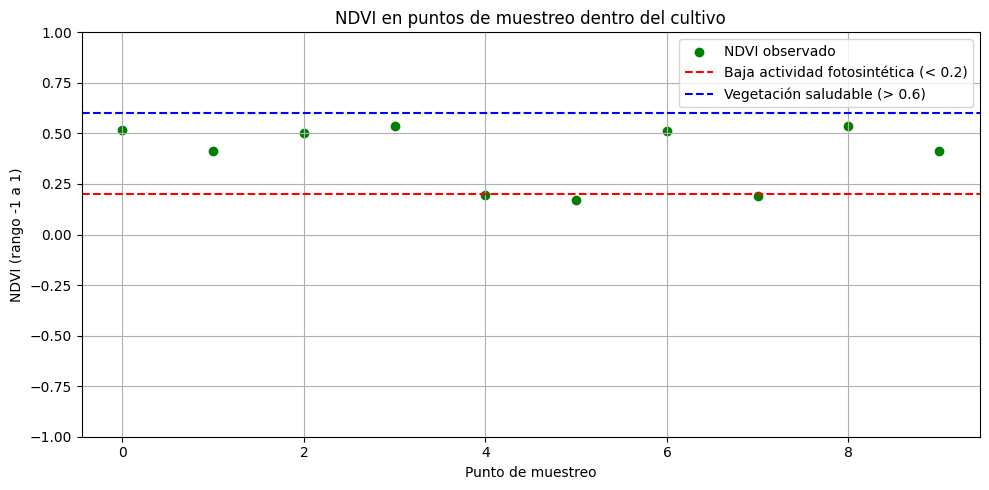

In [ ]:
import matplotlib.pyplot as plt

# Suponiendo que tu DataFrame se llama df y tiene una columna 'NDVI'
ndvi_values = df['NDVI'].values

# Definir umbrales
bajo_umbral = 0.2     # Baja actividad fotosintética
alto_umbral = 0.6     # Vegetación saludable

# Crear el gráfico
plt.figure(figsize=(10, 5))
plt.scatter(range(len(ndvi_values)), ndvi_values, color='green', label='NDVI observado')

# Agregar líneas horizontales para los umbrales
plt.axhline(y=bajo_umbral, color='red', linestyle='--', label='Baja actividad fotosintética (< 0.2)')
plt.axhline(y=alto_umbral, color='blue', linestyle='--', label='Vegetación saludable (> 0.6)')

# Ajustes visuales
plt.title('NDVI en puntos de muestreo dentro del cultivo')
plt.xlabel('Punto de muestreo')
plt.ylabel('NDVI (rango -1 a 1)')
plt.ylim(-1, 1)
plt.grid(True)
plt.legend()
plt.tight_layout()

# Mostrar el gráfico
plt.show()


- La mayoría de los puntos están entre 0.33 y 0.6, lo cual corresponde a un estado de salud vegetal moderada o media actividad fotosintética.

- Hay cierta variabilidad espacial en el cultivo, ya que algunos puntos están más cercanos al límite bajo (alrededor de 0.35) y otros más cercanos al alto (~0.58).

## Análisis de cuerpos de agua

- Cargar imagen Sentinel-2 SR sobre CDMX (escalada a reflectancia).
- Dibujar polígono (user_roi) sobre un lago (ej. Lago de Chapultepec o Xochimilco).
- Generar 10 puntos aleatorios dentro del polígono.
- Extraer valores de todas las bandas reflectivas (B1–B12) en esos puntos.

### Cargar imagen Sentinel-2 SR escalada

In [ ]:
# Crear el mapa centrado en Texcoco
Map = geemap.Map(center=[19.51, -98.88], zoom=11)
Map.add_draw_control()  # Habilitar herramienta de dibujo para capturar ROI

# 1. Cargar imagen Sentinel-2 SR sobre Texcoco
sentinel_raw = ee.ImageCollection("COPERNICUS/S2_SR_HARMONIZED") \
    .filterDate("2023-03-01", "2023-03-31") \
    .filterBounds(ee.Geometry.Point([-98.88, 19.51])) \
    .filter(ee.Filter.lt("CLOUDY_PIXEL_PERCENTAGE", 10)) \
    .first()

# 2. Escalar las bandas ópticas a reflectancia (dividir por 10000)
optical_bands = ['B1','B2','B3','B4','B5','B6','B7','B8','B8A','B9','B11','B12']
sentinel = sentinel_raw.select(optical_bands).divide(10000)

# 3. Visualizar imagen RGB ya escalada
rgb_vis = {
    'bands': ['B4', 'B3', 'B2'],  # rojo, verde, azul
    'min': 0.0,
    'max': 0.3,  # reflejando reflectancia real (0–1), típicamente hasta 0.3 para RGB
    'gamma': 1.2
}
Map.addLayer(sentinel, rgb_vis, "Sentinel-2 reflectancia RGB")
Map

Map(center=[19.51, -98.88], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataG…

### Capturar el polígono del lago

In [ ]:
roi = Map.user_roi
if roi is None:
    print("⚠️ Dibuja primero el polígono del lago.")
else:
    print("✅ Polígono del lago capturado.")

✅ Polígono del lago capturado.


### Generar 10 puntos aleatorios dentro del lago

In [ ]:
# Crear 10 puntos aleatorios dentro del polígono (el lago)
puntos_agua = ee.FeatureCollection.randomPoints(region=roi, points=10, seed=99)

# Visualizar puntos
Map.addLayer(puntos_agua, {'color': 'cyan'}, 'Puntos en el lago')
Map

Map(bottom=3732040.0, center=[19.465459288607992, -98.96825551986696], controls=(WidgetControl(options=['posit…

### Extraer valores de bandas espectrales

In [ ]:
# Extraer valores de TODAS las bandas ópticas en los puntos
espectro_agua = sentinel.sampleRegions(
    collection=puntos_agua,
    scale=10,
    geometries=True
)

### Convertir a DataFrame para análisis

In [ ]:
# Convertir los valores a lista y luego a pandas DataFrame
features = espectro_agua.getInfo()['features']

# Extraer cada banda y coordenadas
data = []
for f in features:
    props = f['properties']
    coords = f['geometry']['coordinates']
    props.update({'lon': coords[0], 'lat': coords[1]})
    data.append(props)

import pandas as pd
df_bandas_agua = pd.DataFrame(data)
df_bandas_agua


,B1,B11,B12,B2,B3,B4,B5,B6,B7,B8,B8A,B9,lon,lat
0,0.0229,0.0063,0.0049,0.0341,0.0628,0.0336,0.1213,0.1855,0.1818,0.1428,0.1131,0.0231,-98.977562,19.461339
1,0.0217,0.0064,0.0070,0.0313,0.0588,0.0310,0.1326,0.2027,0.1996,0.1578,0.1231,0.1172,-98.970415,19.466579
2,0.0207,0.0064,0.0067,0.0308,0.0576,0.0300,0.1335,0.2016,0.1966,0.1556,0.1219,0.1159,-98.970320,19.467122
3,0.0220,0.0066,0.0056,0.0302,0.0566,0.0308,0.1169,0.1848,0.1854,0.1509,0.1155,0.0436,-98.973845,19.466670
4,0.0224,0.0069,0.0059,0.0321,0.0588,0.0307,0.1291,0.2020,0.1993,0.1593,0.1222,0.1175,-98.974417,19.467574
5,0.0239,0.0070,0.0061,0.0352,0.0622,0.0364,0.1215,0.1849,0.1786,0.1424,0.1129,0.0248,-98.973655,19.464863
6,0.0230,0.0061,0.0058,0.0342,0.0662,0.0340,0.1254,0.1774,0.1699,0.1352,0.1077,0.0218,-98.974990,19.459441
7,0.0240,0.0071,0.0074,0.0360,0.0643,0.0358,0.1212,0.1814,0.1719,0.1365,0.1074,0.0229,-98.982040,19.463689
8,0.0193,0.0074,0.0078,0.0290,0.0572,0.0300,0.1143,0.1829,0.1832,0.1501,0.1162,0.0228,-98.963365,19.466307
9,0.0194,0.0074,0.0075,0.0296,0.0579,0.0308,0.1178,0.1855,0.1856,0.1514,0.1144,0.0220,-98.957456,19.469649


In [ ]:
# Crear nombres de punto como P1, P2, ..., P10
df_bandas_agua['Punto'] = ['P' + str(i+1) for i in range(len(df_bandas_agua))]
df_bandas_agua

,B1,B11,B12,B2,B3,B4,B5,B6,B7,B8,B8A,B9,lon,lat,Punto
0,0.0229,0.0063,0.0049,0.0341,0.0628,0.0336,0.1213,0.1855,0.1818,0.1428,0.1131,0.0231,-98.977562,19.461339,P1
1,0.0217,0.0064,0.0070,0.0313,0.0588,0.0310,0.1326,0.2027,0.1996,0.1578,0.1231,0.1172,-98.970415,19.466579,P2
2,0.0207,0.0064,0.0067,0.0308,0.0576,0.0300,0.1335,0.2016,0.1966,0.1556,0.1219,0.1159,-98.970320,19.467122,P3
3,0.0220,0.0066,0.0056,0.0302,0.0566,0.0308,0.1169,0.1848,0.1854,0.1509,0.1155,0.0436,-98.973845,19.466670,P4
4,0.0224,0.0069,0.0059,0.0321,0.0588,0.0307,0.1291,0.2020,0.1993,0.1593,0.1222,0.1175,-98.974417,19.467574,P5
5,0.0239,0.0070,0.0061,0.0352,0.0622,0.0364,0.1215,0.1849,0.1786,0.1424,0.1129,0.0248,-98.973655,19.464863,P6
6,0.0230,0.0061,0.0058,0.0342,0.0662,0.0340,0.1254,0.1774,0.1699,0.1352,0.1077,0.0218,-98.974990,19.459441,P7
7,0.0240,0.0071,0.0074,0.0360,0.0643,0.0358,0.1212,0.1814,0.1719,0.1365,0.1074,0.0229,-98.982040,19.463689,P8
8,0.0193,0.0074,0.0078,0.0290,0.0572,0.0300,0.1143,0.1829,0.1832,0.1501,0.1162,0.0228,-98.963365,19.466307,P9
9,0.0194,0.0074,0.0075,0.0296,0.0579,0.0308,0.1178,0.1855,0.1856,0.1514,0.1144,0.0220,-98.957456,19.469649,P10


### Graficar la firma espectral de cada punto

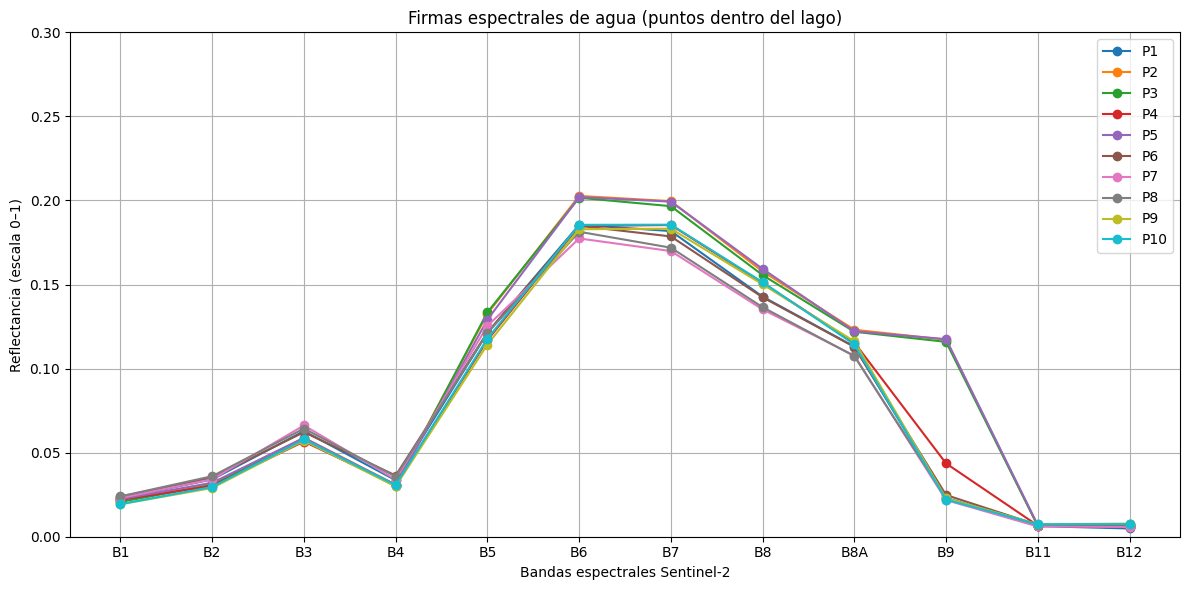

In [ ]:
import matplotlib.pyplot as plt

# Lista de bandas en orden
bandas = ['B1','B2','B3','B4','B5','B6','B7','B8','B8A','B9','B11','B12']

# Crear figura
plt.figure(figsize=(12, 6))

# Graficar una línea por punto
for _, row in df_bandas_agua.iterrows():
    valores = [row[b] for b in bandas]
    plt.plot(bandas, valores, marker='o', label=row['Punto'])

# Estética del gráfico
plt.title('Firmas espectrales de agua (puntos dentro del lago)')
plt.xlabel('Bandas espectrales Sentinel-2')
plt.ylabel('Reflectancia (escala 0–1)')
plt.ylim(0, 0.3)  # agua normalmente tiene reflectancia baja
plt.grid(True)
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()


**Agua contaminada - presencia de algas**

Color del agua

![Firma espectral del lago](https://drive.google.com/uc?export=view&id=1zkx4CG36bXgpuCmhNlEcGehqf1u-7Ba4)

Firma espectral

![Imagen 3](https://drive.google.com/uc?export=view&id=1rC9llJ-PeVxZv7rKvE9i6yRt0TMuRbSz)

---
**Agua contaminada - presencia de platas flotantes**

Fotografía del color del agua

![Imagen 1](https://drive.google.com/uc?export=view&id=1fGn0QJjYtsafcRdMJhC7s3TbJgzs_jFM)

Firma espectral

![Imagen 2](https://drive.google.com/uc?export=view&id=1q0Uf0Qca5zq8BFXP-Do8ZuowwiUAWS5k)

---
**Agua contaminada - Aguas turbias**

Fotografía de color del agua

![Imagen 4](https://drive.google.com/uc?export=view&id=13WikjZYm9AHYRfuCHGFZYfCFEjyobp7J)

Firma espectral

![Imagen 5](https://drive.google.com/uc?export=view&id=1Fd7WBJyRE5f0R9OUSlNWY6-TQTBXqI5r)


(Wang et al., 2019)

Comportamiento típico del agua con posible turbidez o material en suspensión:
1. B1–B4 (azul a rojo): Reflectancia moderada (~0.12–0.16). Esto es coherente con agua poco profunda o con sedimentos.

2. Pico fuerte en B5–B8 (Red Edge + NIR):
Esto no es típico del agua pura, pero puede indicar:

    - Vegetación flotante o sumergida (algas, lirios, etc.).

    - Contaminación orgánica, alta productividad biológica.

    - Efecto de píxeles mixtos (agua + borde con vegetación).

3. Caída fuerte en B9 (vapor de agua) y en B11–B12 (SWIR):
Esperado para agua, ya que absorbe fuertemente en estas bandas.

## Clasificación no supervisada (K-means) con Sentinel-2

### Seleccionar bandas útiles para clasificación

In [ ]:
# Seleccionar bandas relevantes (escala ya aplicada previamente)
bandas_clasificacion = sentinel.select(['B2', 'B3', 'B4', 'B5', 'B6', 'B8'])

### Extraer muestra aleatoria de píxeles en toda la imagen

In [ ]:
# 2. Tomar una muestra de píxeles aleatorios en toda la imagen
training = bandas_clasificacion.sample(
    region=sentinel.geometry(),  # toda el área de la imagen
    scale=10,
    numPixels=5000,
    seed=42
)

### Entrenar el modelo K-means con 6 clases

In [ ]:
# 3. Entrenar el modelo de clustering K-means
n_clusters = 5  # puedes ajustar entre 3 y 6 dependiendo de la heterogeneidad
clusterer = ee.Clusterer.wekaKMeans(n_clusters).train(training)

# 4. Aplicar clasificación no supervisada a la imagen completa
clasificacion = bandas_clasificacion.cluster(clusterer)

In [ ]:
# Asignar colores aleatorios a cada clase
clasificacion_coloreada = clasificacion.randomVisualizer()

# Añadir al mapa
Map.addLayer(clasificacion_coloreada, {}, f'Clasificación K-means (k={n_clusters})')
Map

Map(bottom=3732040.0, center=[19.465459288607992, -98.9682126045227], controls=(WidgetControl(options=['positi…

### calcular y visualizar NDVI, NDWI y NDBI

**Calcular los índices**

In [ ]:
# Asegúrate de que 'sentinel' ya está escalada a reflectancia
# NDVI: Normalized Difference Vegetation Index
ndvi = sentinel.normalizedDifference(['B8', 'B4']).rename('NDVI')

# NDWI: Normalized Difference Water Index
ndwi = sentinel.normalizedDifference(['B3', 'B8']).rename('NDWI')

# NDBI: Normalized Difference Built-up Index
ndbi = sentinel.normalizedDifference(['B11', 'B8']).rename('NDBI')


**Visualizar cada índice con su paleta adecuada**

In [ ]:
# Añadir NDVI al mapa
Map.addLayer(ndvi, {
    'min': -1,
    'max': 1,
    'palette': ['brown', 'yellow', 'green']
}, 'NDVI (vegetación)')

# Añadir NDWI al mapa
Map.addLayer(ndwi, {
    'min': -1,
    'max': 1,
    'palette': ['white', 'blue']
}, 'NDWI (agua)')

# Añadir NDBI al mapa
Map.addLayer(ndbi, {
    'min': -1,
    'max': 1,
    'palette': ['white', 'gray', 'black']
}, 'NDBI (urbano)')
Map

Map(bottom=7462665.0, center=[19.488015513755798, -98.94375085830688], controls=(WidgetControl(options=['posit…

NDBI — Valores e interpretación visual:
- NDBI < 0 → valores negativos (usualmente vegetación, agua)
→ en la paleta: blanco

- NDBI ≈ 0 → áreas mixtas, transicionales
→ en la paleta: gris
- NDBI > 0 → superficies construidas, urbano, techos, concreto
→ en la paleta: negro

---
NDVI

- Marrón → suelo
- Amarillo → vegetación pobre
- Verde → vegetación saludable

---

NDWI
- Blanco → no agua
- Azul claro a oscuro → más contenido de agua